In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

data = pd.read_csv('cloud-data/bus_data_modified.csv')
# convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# shift all timestamps 6 hrs back
data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=4)
# only use the latitude and longitude columns between certain values
data = data[(data['latitude'] > 40.4) & (data['latitude'] < 40.53)]
data = data[(data['longitude'] > -74.5) & (data['longitude'] < -74.3)]
data.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
0,4855,4131,Transit Bus,212.735226,LX Route,02:23 PM,-74.433571,40.519749,0,67,101,402213,111417,2024-10-31 14:24:00,0.000000,Quads
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 14:24:00,0.402985,Livingston Student Center
2,4873,4191,Transit Bus,240.802514,B Route,02:23 PM,-74.457712,40.523463,8,67,101,402329,113278,2024-10-31 14:24:00,0.119403,NaN
3,4876,4194,Transit Bus,299.246496,B Route,02:23 PM,-74.438946,40.521624,4,67,102,402330,113250,2024-10-31 14:24:00,0.059701,NaN
4,17624,4002,Heavy Duty Transit LF,226.694476,REXB Route,02:23 PM,-74.438830,40.483538,2,68,102,402643,112511,2024-10-31 14:24:00,0.029412,NaN


In [3]:
# create a data frame with unique timestamps as index and columns with the number of buses on a given route at the stop
route = 'LX Route'
data_route = data[data['routeName'] == route]

stops = data_route['stop'].unique()

timestamps = data_route['timestamp'].unique()

# convert timestamps to dataframe with stops as columns
df = pd.DataFrame(index=timestamps, columns=stops)
df.head()

,Quads,Livingston Student Center,NaN,College Avenue Student Center,Student Activities Center (NB),The Yard,Livingston Plaza
2024-10-31 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31 14:24:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31 14:25:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31 14:25:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31 14:26:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for timestamp in timestamps:
    data_at_timestamp = data_route[data_route['timestamp'] == timestamp]

    for stop in stops:
        data_at_stop = data_at_timestamp[data_at_timestamp['stop'] == stop]
        df.at[timestamp, stop] = len(data_at_stop)
    
    data_nan = data_at_timestamp[data_at_timestamp.isna().any(axis=1)]
    df.at[timestamp, 'NaN'] = len(data_nan)

for column in df.columns:
    df[column] = pd.to_numeric(df[column])

    if type(column) == float:
        df.drop(column, axis=1, inplace=True)

df.head()

,Quads,Livingston Student Center,College Avenue Student Center,Student Activities Center (NB),The Yard,Livingston Plaza,NaN
2024-10-31 14:24:00,1,2,2,2,0,0,7.0
2024-10-31 14:24:31,1,2,1,2,0,0,8.0
2024-10-31 14:25:01,1,2,0,0,0,0,9.0
2024-10-31 14:25:32,2,2,0,0,1,0,7.0
2024-10-31 14:26:02,2,1,0,0,2,0,7.0


In [5]:
df.describe()

,Quads,Livingston Student Center,College Avenue Student Center,Student Activities Center (NB),The Yard,Livingston Plaza,NaN
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,0.176986,0.713565,0.570885,0.194346,0.364719,0.329669,4.542201
std,0.421997,0.855968,0.788133,0.438335,0.607007,0.587519,2.549489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,7.000000
max,3.000000,5.000000,6.000000,3.000000,4.000000,4.000000,11.000000


In [6]:
bus_id = data_route['id'].unique()[1]

data_bus = data_route[data_route['id'] == bus_id]

start_stop = data_bus['stop'].iloc[0]

data_bus.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 14:24:00,0.402985,Livingston Student Center
49,4859,4177,Transit Bus,207.373263,LX Route,02:24 PM,-74.436504,40.524102,17,67,101,402325,111417,2024-10-31 14:24:31,0.253731,Livingston Student Center
97,4859,4177,Transit Bus,233.959917,LX Route,02:25 PM,-74.436543,40.524075,4,67,101,402325,111417,2024-10-31 14:25:01,0.059701,Livingston Student Center
145,4859,4177,Transit Bus,246.801409,LX Route,02:25 PM,-74.436537,40.524095,0,67,101,402325,111417,2024-10-31 14:25:32,0.000000,Livingston Student Center
192,4859,4177,Transit Bus,75.358115,LX Route,02:26 PM,-74.436536,40.524077,0,67,101,402325,111417,2024-10-31 14:26:02,0.000000,Livingston Student Center


In [ ]:
# loop through all the times in the data_bus dataframe and create two new columns
# one to measure a bus's time to complete the route and another to measure the time waiting at a stop
# add these columns to the data_bus dataframe

data_bus['time_to_complete'] = 0
data_bus['time_waiting'] = 0

for i in range(1, len(data_bus)):
    # if the bus is not at the start stop set the time to complete to the previous time to complete + the time difference
    # and time waiting to 0
    if data_bus['stop'].iloc[i] != start_stop:
        data_bus['time_to_complete'].iloc[i] = data_bus['time_to_complete'].iloc[i-1] + (data_bus['timestamp'].iloc[i] - data_bus['timestamp'].iloc[i-1]).seconds
        data_bus['time_waiting'].iloc[i] = 0
    # if the bus is at the start stop set the time waiting to the previous time waiting + the time difference
    # and time to complete to 0
    else:
        data_bus['time_waiting'].iloc[i] = data_bus['time_waiting'].iloc[i-1] + (data_bus['timestamp'].iloc[i] - data_bus['timestamp'].iloc[i-1]).seconds
        data_bus['time_to_complete'].iloc[i] = 0

    # if the time difference between the current and previous timestamp is greater than 5 minutes
    # set the time waiting and time to complete to 0
    if (data_bus['timestamp'].iloc[i] - data_bus['timestamp'].iloc[i-1]).seconds > 300:
        data_bus['time_waiting'].iloc[i] = 0
        data_bus['time_to_complete'].iloc[i] = 0

data_bus.head()
    

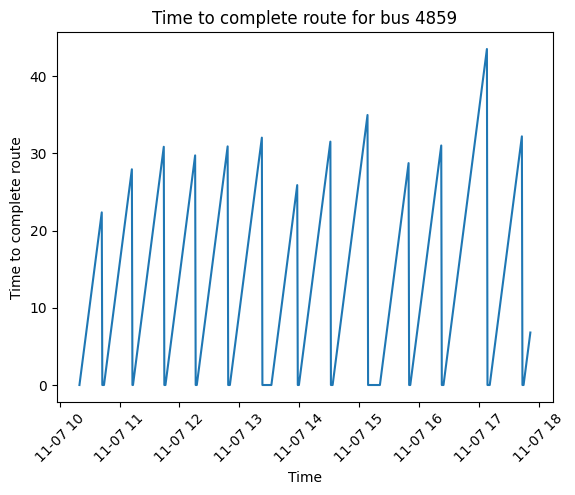

In [ ]:
# plot the time to complete the route for a given bus

# look at the data for a specific day
limited = data_bus[(data_bus['timestamp'] > '2024-11-07') & (data_bus['timestamp'] < '2024-11-10')]

plt.plot(limited['timestamp'], limited['time_to_complete']/60)
plt.xlabel('Time of Day')
plt.ylabel('Time to complete route')
plt.xticks(rotation=45)
plt.title('Time to complete route for bus ' + str(bus_id))
plt.show()

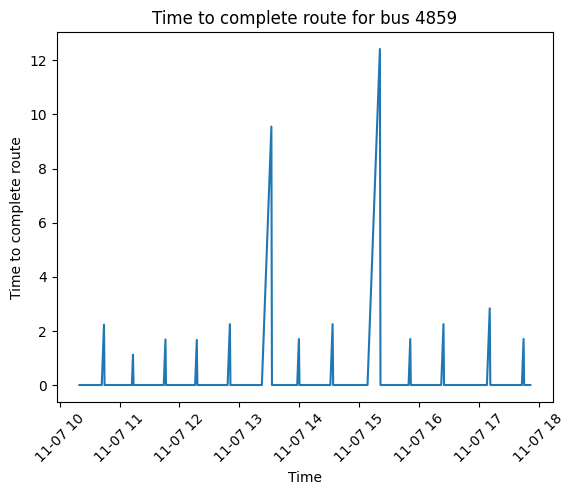

In [ ]:
# plot the time to complete the route for a given bus

# look at the data for a specific day
limited = data_bus[(data_bus['timestamp'] > '2024-11-07') & (data_bus['timestamp'] < '2024-11-10')]

plt.plot(limited['timestamp'], limited['time_waiting']/60)
plt.xlabel('Time of Day')
plt.ylabel('Time waiting at stop')
plt.xticks(rotation=45)
plt.title('Time waiting for bus ' + str(bus_id))
plt.show()